# Cognitive Modelling: Final Project
## Part 1

Name: Vishal Sreenivasan
Student No: S4196392

# Importing Libraries

In [1]:
from model import Model
from dmchunk import Chunk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Conversion functions

In [2]:
def noise(s):
    rand = np.random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

def feedback(r, x):
     return ((r - x) / r) ** 2

# Acerbi Model

In [3]:
def acerbi():
    
    n_participants = 10

    df = pd.DataFrame(columns = ["int", "resp", "feedback", "Subject", "Block", "Run", "Task", "Main"])

    short_intervals = np.linspace(450, 825, num = 6)
    medium_intervals = np.linspace(600, 975, num = 6)
    long_intervals = np.linspace(750, 1125, num = 6)

    prob = {"Short Uniform": [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
            "Long Uniform": [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
            "Medium Uniform": [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
            "Medium spiked": [1/12, 7/12, 1/12, 1/12, 1/12, 1/12]}
    
    for subj in range(n_participants):
        
        if subj < 4:
            conditions = {"Short Uniform": short_intervals,
                          "Long Uniform": long_intervals}
            task = 1
        
        else:
            conditions = {"Medium Uniform": medium_intervals,
                          "Medium spiked": medium_intervals}
            task = 2
            
        for cond in conditions:
            m = Model()
            main = False
            
            #trial session
            train = np.random.randint(500, 1500)
            
            #2 test sessions
            test = train + 1000
            
            for trial in range(test):
                #initial 1s
                m.time += 1
                
                #random delay
                delay = np.random.uniform(0.25, 1)
                m.time += delay

                #interval
                interval = np.random.choice(conditions[cond], p = prob[cond])
                m.time += interval /1000
                pulses = time_to_pulses(interval / 1000)
                
                #Appearance of yellow dot
                m.time += 0.0185
                
                #Chunk is stored in DM
                chunk = Chunk(name = f"pulse{pulses}", slots = {"isa" : "time", "pulses": pulses})
                m.add_encounter(chunk)
                
                #wait of 250ms
                m.time += 0.25
                
                #reproduction of time interval
                retrieve = Chunk(name = "retrieve", slots = {"isa": "time"})
                chunk, latency = m.retrieve_blended_trace(retrieve, "pulses")

                time = pulses_to_time(chunk)
                m.time += time
                
                #delay of 450ms-850ms before feedback
                m.time += np.random.uniform(0.45, 0.85)
                
                #feedback
                fb = feedback(interval, time * 1000) * 1000
                
                #feedback display of 62ms
                m.time += 0.062
                
                #training sessions are recorded
                if trial > train:
                    main = True
                
                    df = df.append({"int": interval,
                                    "resp": time * 1000,
                                    "feedback": fb,
                                    "Subject": subj + 1,
                                    "Block": cond,
                                    "Run": trial + 1,
                                    "Task": task,
                                    "Main": main}, ignore_index = True)
    return df

In [4]:
df = acerbi()

In [5]:
df.to_csv("acerbi.csv", index = False)

# Plot function

In [6]:
def plot_data(df, cond_A, cond_B):
    df = df[df["Main"] == True]
    intervals = df[df["Block"].isin([cond_A, cond_B])]

    fig = plt.figure(figsize = (12, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    #single subject
    first_subject = intervals["Subject"].unique()[0]
    X = intervals[intervals["Subject"] == first_subject]

    a1 = X[X["Block"] == cond_A]    
    a1 = a1.groupby(["int"])["resp"].mean().reset_index()
    a1["bias"] = a1["resp"] - a1["int"]

    a2 = X[X["Block"] == cond_B]    
    a2 = a2.groupby(["int"])["resp"].mean().reset_index()
    a2["bias"] = a2["resp"] - a2["int"]

    ax1.scatter(a1["int"], a1["bias"], s=10, c='r', marker="o", label=cond_A)
    ax1.scatter(a2["int"], a2["bias"], s=10, c='g', marker="o", label=cond_B)
    ax1.axhline(y=0, color='gray', linestyle='-')
    ax1.set(xlabel = "Physical Time Interval (ms)", ylabel = "Response Bias (ms)")
    ax1.set_title("Single Subject")

    #group
    a1 = intervals[intervals["Block"] == cond_A]    
    a1 = a1.groupby(["int"])["resp"].mean().reset_index()
    a1["bias"] = a1["resp"] - a1["int"]

    a2 = intervals[intervals["Block"] == cond_B]    
    a2 = a2.groupby(["int"])["resp"].mean().reset_index()
    a2["bias"] = a2["resp"] - a2["int"]

    ax2.scatter(a1["int"], a1["bias"], s=10, c='r', marker="o", label=cond_A)
    ax2.scatter(a2["int"], a2["bias"], s=10, c='g', marker="o", label=cond_B)
    ax2.axhline(y=0, color='gray', linestyle='-')
    ax2.set(xlabel = "Physical Time Interval (ms)", ylabel = "Response Bias (ms)")
    ax2.set_title("Group Mean")
    
    ax1.legend(loc='upper right')
    ax2.legend(loc = 'upper right')
    plt.savefig(f"acerbi_{cond_A[0]}{cond_B[0]}.png")
    plt.show()

# Plot of Short and Long Uniform distributions

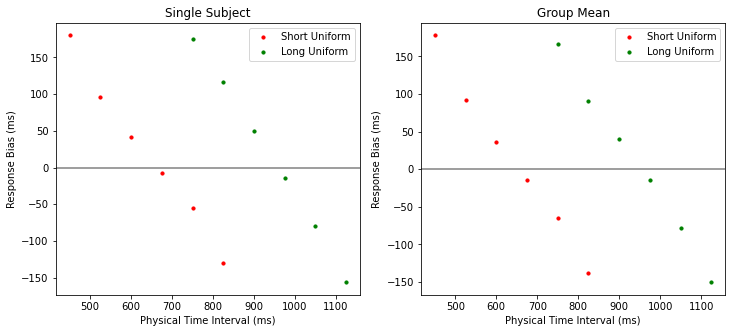

In [7]:
plot_data(df, "Short Uniform", "Long Uniform")

# Plot of Medium Uniform and Medium Peaked distributions

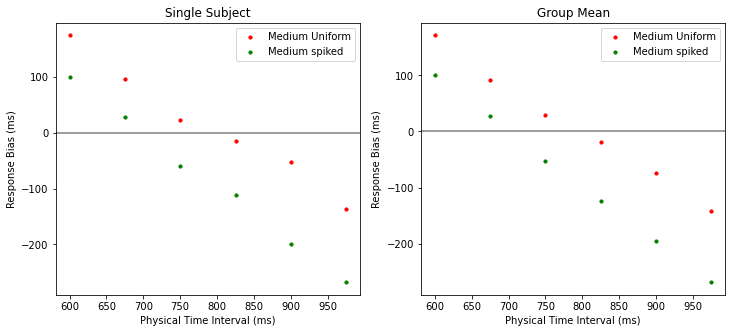

In [8]:
plot_data(df, "Medium Uniform", "Medium spiked")